# Unsupervised SAM2 Segmentation Debug Walkthrough

This notebook runs the unsupervised SAM2 workflow on a single image and visualises every iteration of the prompt-expansion loop. The goal is to quickly inspect how prompts, masks, logits, and the final mask pool evolve during inference.

## Notebook Outline
- Configure the dataset sample and build the SAM2 predictor.
- Inspect the SLIC pre-segmentation that defines graph nodes/superpixels.
- Execute the iterative algorithm while capturing every intermediate state.
- For each step, display prompts, masks, logits and derived metrics.
- Review the deduplicated mask pool and the final selection score breakdown.

In [1]:
from pathlib import Path
import sys
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
SAM2_ROOT = PROJECT_ROOT.parent / "sam2"
if SAM2_ROOT.exists() and str(SAM2_ROOT) not in sys.path:
    sys.path.insert(0, str(SAM2_ROOT))

In [2]:
%matplotlib inline

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = False


In [3]:
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

from debug_test import (
    MAIN_DIR,
    StepRecord,
    _load_constants,
    _run_prediction,
    _evaluate_candidates,
    _refine_with_low_res,
    _ensure_uint8_image,
)
from configs.pipeline_config import load_pipeline_config
from datasets.dataset import load_dataset
from image_processings.image_pre_seg import image_i_segment, change_image_type
from image_processings.info import Info
from image_processings.pick_obj import pick_obj_using_heuristic, pick_obj_using_entropy, pick_obj_using_edge_gradient
from image_processings.mask_cluster import cluster_masks_by_area, select_middle_cluster_entry
from metrics.metric import calculate_miou, calculate_dice
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


In [4]:
# Configuration switches ----------------------------------------------------
DATASET_NAME = "auto"  # use "auto" to follow pipeline.json or override with a dataset folder name
IMAGE_INDEX = 4        # change to inspect another sample within the dataset
DEVICE = "cpu"         # keep on CPU for debugging convenience

constants = _load_constants()
pipeline_cfg = load_pipeline_config(MAIN_DIR / constants["pipeline_cfg"])

chosen_dataset = pipeline_cfg.dataset.name if DATASET_NAME == "auto" else DATASET_NAME

images, gt_masks, image_names = load_dataset(
    chosen_dataset,
    data_root=None,
    target_long_edge=pipeline_cfg.dataset.target_long_edge,
    return_paths=True,
)

if not images:
    raise RuntimeError(f"Dataset '{chosen_dataset}' is empty.")

IMAGE_INDEX = max(0, min(IMAGE_INDEX, len(images) - 1))
image_rgb = images[IMAGE_INDEX]
gt_mask_raw = gt_masks[IMAGE_INDEX]
image_name = image_names[IMAGE_INDEX]

predictor = SAM2ImagePredictor(
    build_sam2(
        constants["model_cfg"],
        constants["checkpoint"],
        device=DEVICE,
    )
)

display(Markdown(
    f"**Dataset:** `{chosen_dataset}` — **Image index:** {IMAGE_INDEX} — **Filename:** `{image_name}`"
))
print(f"Image shape (after dataset resize): {image_rgb.shape}")


**Dataset:** `cropped` — **Image index:** 4 — **Filename:** `0004.png`

Image shape (after dataset resize): (256, 260, 3)


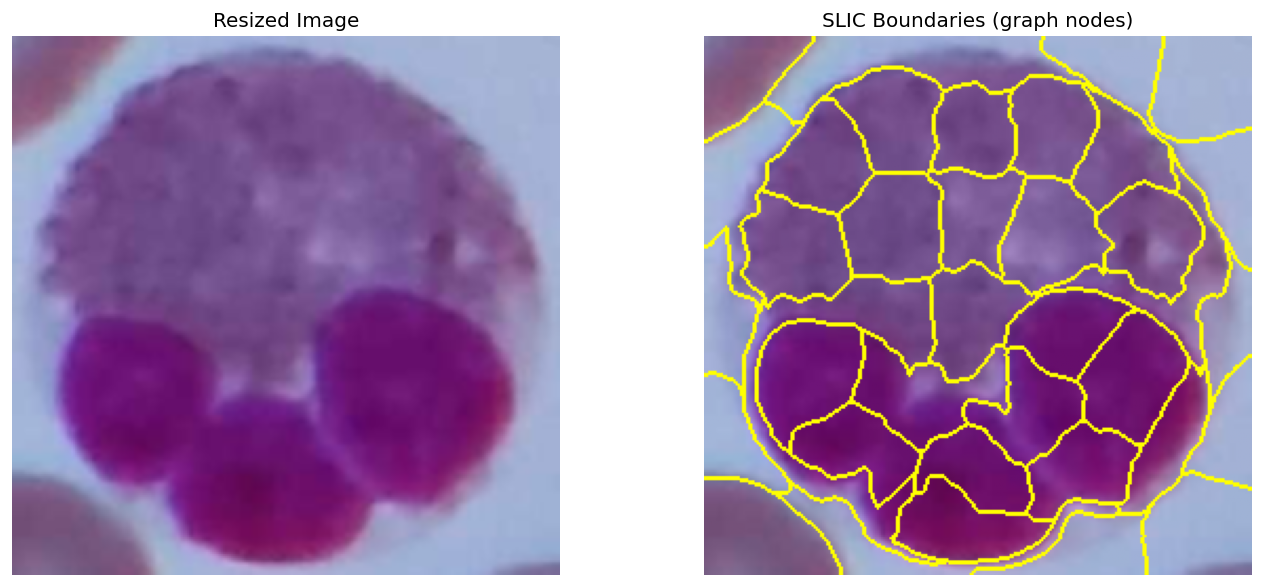

In [5]:
# SLIC preprocessing -------------------------------------------------------
pre_cfg = pipeline_cfg.preprocessing
slic_cfg = pre_cfg.slic

pre_segment = image_i_segment(
    image=image_rgb,
    new_size_of_image=pre_cfg.image_size,
    num_node_for_graph=pre_cfg.num_graph_nodes,
    compactness_in_SLIC=slic_cfg.compactness,
    sigma_in_SLIC=slic_cfg.sigma,
    min_size_factor_in_SLIC=slic_cfg.min_size_factor,
    max_size_factor_in_SLIC=slic_cfg.max_size_factor,
)

img_resized_np = change_image_type(pre_segment.image_resized, "np.array")
segments_tensor = pre_segment.segment_without_padding
segments_np = segments_tensor.cpu().numpy() if hasattr(segments_tensor, "cpu") else np.array(segments_tensor)
vis_image = _ensure_uint8_image(img_resized_np)

# align the GT mask to the working resolution for later metric calculations
if gt_mask_raw.shape != vis_image.shape[:2]:
    gt_mask_aligned = cv2.resize(
        gt_mask_raw.astype(np.uint8),
        (vis_image.shape[1], vis_image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    ) > 0
else:
    gt_mask_aligned = gt_mask_raw.astype(bool)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(vis_image)
axes[0].set_title("Resized Image")
axes[0].axis("off")

axes[1].imshow(mark_boundaries(img_as_float(vis_image), segments_np))
axes[1].set_title("SLIC Boundaries (graph nodes)")
axes[1].axis("off")
plt.tight_layout()


In [6]:
# Full pipeline execution with detailed tracking --------------------------

def run_segmentation_with_full_history(pre_segment, gt_mask_bool, config, predictor):
    img_resized = change_image_type(pre_segment.image_resized, "np.array")
    segment_tensor = pre_segment.segment_without_padding
    segment = segment_tensor.cpu().numpy() if hasattr(segment_tensor, "cpu") else np.array(segment_tensor)
    vis_img = _ensure_uint8_image(img_resized)

    predictor.set_image(vis_img)

    info = Info(
        segment=segment,
        logits=None,
        image=vis_img,
        graph=pre_segment.graph,
        settings=config.algorithm,
        debug_mode=False,
        mask_prompt_source=config.sam.mask_prompt_source,
    )

    history = []

    initial_bundle = info.build_initial_prompts()
    initial_result = _run_prediction(predictor, initial_bundle, info, config.sam)
    info.record_low_res_mask(initial_result.low_res_mask)

    logits = initial_result.logits
    mask = initial_result.mask

    history.append(
        StepRecord(
            iteration=0,
            stage="initial",
            prompts=initial_bundle,
            logits=logits,
            mask=mask,
            positive_mask=info.prompt_mask.copy(),
            candidate_id=initial_result.candidate_id if initial_result.candidate_id != -1 else None,
        )
    )
    info.add_pool_entry(
        mask=mask,
        logits=logits,
        score=initial_result.score,
        iteration=0,
        prompts=initial_bundle,
        candidate_id=initial_result.candidate_id if initial_result.candidate_id != -1 else None,
        positive_mask=info.prompt_mask.copy(),
    )

    for iteration in range(1, config.algorithm.max_iterations + 1):
        info.update_from_logits(logits)
        candidates = info.get_candidates()
        if not candidates:
            break

        best_candidate = _evaluate_candidates(predictor, info, config.sam, candidates)
        if best_candidate is None:
            break

        info.commit_candidate(best_candidate.candidate_id)
        logits = best_candidate.logits
        mask = best_candidate.mask
        info.record_low_res_mask(best_candidate.low_res_mask)
        info.add_pool_entry(
            mask=mask,
            logits=logits,
            score=best_candidate.score,
            iteration=iteration,
            prompts=best_candidate.prompts,
            candidate_id=best_candidate.candidate_id,
            positive_mask=info.prompt_mask.copy(),
        )
        history.append(
            StepRecord(
                iteration=iteration,
                stage="promotion",
                prompts=best_candidate.prompts,
                logits=logits,
                mask=mask,
                positive_mask=info.prompt_mask.copy(),
                candidate_id=best_candidate.candidate_id,
            )
        )

    if config.sam.refine_with_previous_low_res:
        selection_prompts = info.build_prompts(candidate_id=None)
        logits, mask = _refine_with_low_res(
            predictor,
            info,
            config.sam,
            logits,
            config.sam.refine_rounds,
        )
        info.add_pool_entry(
            mask=mask,
            logits=logits,
            score=None,
            iteration=len(history),
            prompts=selection_prompts,
            candidate_id=None,
            positive_mask=info.prompt_mask.copy(),
        )
        history.append(
            StepRecord(
                iteration=len(history),
                stage="refine",
                prompts=selection_prompts,
                logits=logits,
                mask=mask,
                positive_mask=info.prompt_mask.copy(),
                candidate_id=None,
            )
        )

    info.deduplicate_mask_pool(info.settings.mask_pool_iou_threshold)
    selection_strategy = info.settings.selection_strategy.lower()
    selected_entry, pool_stats, scored_details = pick_obj_using_heuristic(
        vis_img,
        info.get_mask_pool(),
        target_area_ratio=info.settings.target_area_ratio,
    )

    if selected_entry is not None:
        info.set_pool_stats(pool_stats)
        selection_strategy = info.settings.selection_strategy.lower()
        final_entry = selected_entry
        selection_meta = {"method": selection_strategy}
        if selection_strategy == "cluster_middle":
            clustered_entry, cluster_meta = select_middle_cluster_entry(info.get_mask_pool(), n_clusters=3)
            selection_meta["cluster_meta"] = cluster_meta
            if clustered_entry is not None:
                final_entry = clustered_entry
        else:
            selection_meta["cluster_meta"] = None

        info.selection_metadata = selection_meta
        info.selected_entry = final_entry
        mask = np.asarray(final_entry["mask"], dtype=bool)
        entry_logits = final_entry.get("logits")
        if entry_logits is not None:
            logits = entry_logits
        final_prompts = final_entry.get("prompts", info.build_prompts(candidate_id=None))
        final_positive_mask = final_entry.get("positive_mask", info.prompt_mask.copy())
        history.append(
            StepRecord(
                iteration=len(history),
                stage="selection",
                prompts=final_prompts,
                logits=logits,
                mask=mask,
                positive_mask=final_positive_mask,
                candidate_id=final_entry.get("candidate_id"),
            )
        )
    else:
        pool_stats = {}
        scored_details = []
        info.selection_metadata = {"method": selection_strategy, "cluster_meta": None}

    result_mask = np.asarray(mask, dtype=bool)
    gt_bool = gt_mask_bool.astype(bool)

    intersection = np.logical_and(result_mask, gt_bool).sum()
    union = np.logical_or(result_mask, gt_bool).sum()
    iou = float(intersection / union) if union else 1.0
    dice = float(2 * intersection / (result_mask.sum() + gt_bool.sum())) if (result_mask.sum() + gt_bool.sum()) else 1.0

    miou, _ = calculate_miou([result_mask], [gt_bool])
    dice_mean, _ = calculate_dice([result_mask], [gt_bool])

    return {
        "mask": result_mask,
        "history": history,
        "info": info,
        "vis_image": vis_img,
        "segments": segment,
        "gt_mask": gt_bool,
        "pool_stats": pool_stats,
        "scored_details": scored_details,
        "selection_meta": getattr(info, "selection_metadata", {}),
        "metrics": {"iou": iou, "dice": dice, "miou": miou, "dice_mean": dice_mean},
    }

result = run_segmentation_with_full_history(pre_segment, gt_mask_aligned, pipeline_cfg, predictor)

history = result["history"]
info = result["info"]
vis_image = result["vis_image"]
segments_np = result["segments"]
final_mask = result["mask"]
gt_mask_aligned = result["gt_mask"]
pool_stats = result["pool_stats"]
scored_details = result["scored_details"]

print(f"Total recorded steps: {len(history)} (stages: {[step.stage for step in history]})")
print(f"Final IoU vs GT: {result['metrics']['iou']:.4f}, Dice: {result['metrics']['dice']:.4f}")


Total recorded steps: 4 (stages: ['initial', 'promotion', 'refine', 'selection'])
Final IoU vs GT: 0.8971, Dice: 0.9457


In [7]:
# Helper utilities for visualising each iteration -------------------------

def overlay_mask(image, mask, color=(0, 255, 0), alpha=0.45):
    overlay = image.astype(np.float32).copy()
    mask_bool = np.asarray(mask, dtype=bool)
    overlay[mask_bool] = overlay[mask_bool] * (1 - alpha) + np.array(color, dtype=np.float32) * alpha
    return np.clip(overlay, 0, 255).astype(np.uint8)


def find_pool_entry(step_mask, mask_pool):
    for entry in mask_pool:
        if Info._mask_iou(entry["mask"], step_mask) > 0.999:
            return entry
    return None


def plot_step(step_idx, step, vis_img, segments, gt_mask=None):
    mask_bool = np.asarray(step.mask, dtype=bool)
    pos_points = step.prompts.points[step.prompts.labels == 1]
    neg_points = step.prompts.points[step.prompts.labels == 0]

    compare = None
    if gt_mask is not None:
        compare = np.asarray(gt_mask, dtype=bool)
        inter = np.logical_and(mask_bool, compare).sum()
        union = np.logical_or(mask_bool, compare).sum()
        iou = float(inter / union) if union else 1.0
        denom = mask_bool.sum() + compare.sum()
        dice = float(2 * inter / denom) if denom else 1.0
    else:
        iou = dice = float("nan")

    pool_entry = find_pool_entry(mask_bool, info.get_mask_pool())
    pool_score = pool_entry.get("score_details", {}).get("score") if pool_entry else None

    boundary_img = mark_boundaries(img_as_float(vis_img), segments)
    overlay = overlay_mask(vis_img, mask_bool, (0, 220, 0), alpha=0.45)
    if compare is not None:
        overlay = overlay_mask(overlay, np.logical_and(compare, ~mask_bool), (255, 0, 0), alpha=0.35)

    logits = np.array(step.logits)
    if logits.ndim == 3 and logits.shape[0] == 1:
        logits = logits[0]
    logits = logits.astype(np.float32)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].imshow(boundary_img)
    if pos_points.size:
        axes[0].scatter(pos_points[:, 0], pos_points[:, 1], marker='*', s=140, c='lime', edgecolor='white', linewidth=1.2, label='positive')
    if neg_points.size:
        axes[0].scatter(neg_points[:, 0], neg_points[:, 1], marker='*', s=140, c='red', edgecolor='white', linewidth=1.2, label='negative')
    axes[0].set_title(f"Step {step_idx}: {step.stage}")
    axes[0].axis('off')
    if pos_points.size or neg_points.size:
        axes[0].legend(loc='upper right')

    axes[1].imshow(overlay)
    title = "Mask overlay"
    if compare is not None:
        title += f"\nIoU={iou:.3f}, Dice={dice:.3f}"
    if pool_score is not None:
        title += f"\nPool score={pool_score:.3f}"
    axes[1].set_title(title)
    axes[1].axis('off')

    im = axes[2].imshow(logits, cmap='coolwarm')
    axes[2].set_title("Logits (SAM2 output)")
    axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()


def describe_step(step_idx, step):
    pos_count = int(np.sum(step.prompts.labels == 1))
    neg_count = int(np.sum(step.prompts.labels == 0))
    candidate_text = step.candidate_id if step.candidate_id is not None else "—"
    entry = find_pool_entry(step.mask, info.get_mask_pool())
    score_text = ""
    if entry and "score_details" in entry:
        score_text = f"; pool score: {entry['score_details']['score']:.3f}"
    display(Markdown(
        f"**Step {step_idx}: {step.stage.title()}** — candidate: `{candidate_text}`, +/-: {pos_count}/{neg_count}{score_text}"
    ))
    plot_step(step_idx, step, vis_image, segments_np, gt_mask=gt_mask_aligned)


**Step 0: Initial** — candidate: `—`, +/-: 3/4; pool score: -0.000

**Step 1: Promotion** — candidate: `20`, +/-: 15/4; pool score: 5.000

**Step 2: Refine** — candidate: `—`, +/-: 22/4

**Step 3: Selection** — candidate: `20`, +/-: 15/4; pool score: 5.000

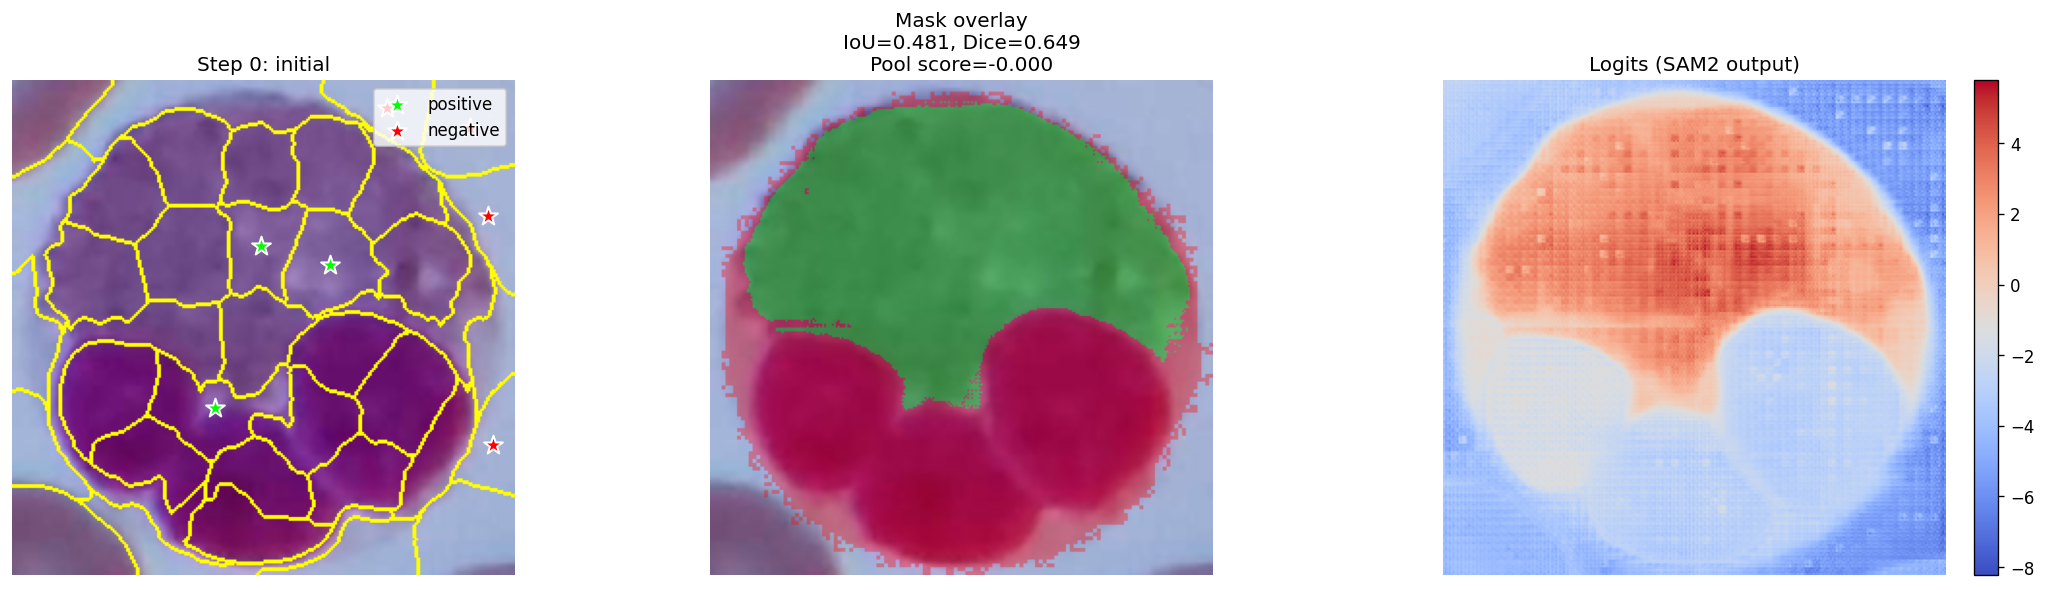

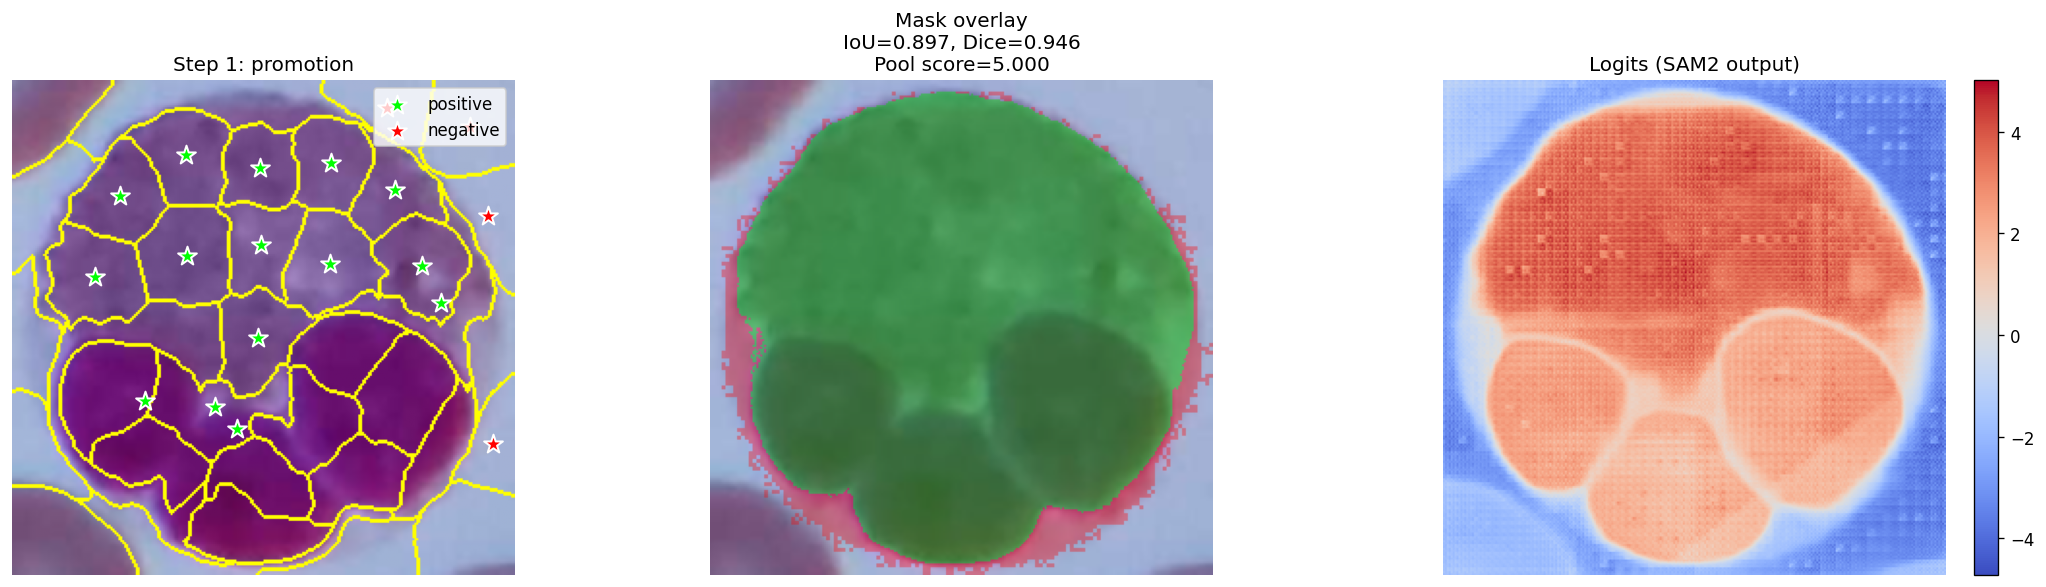

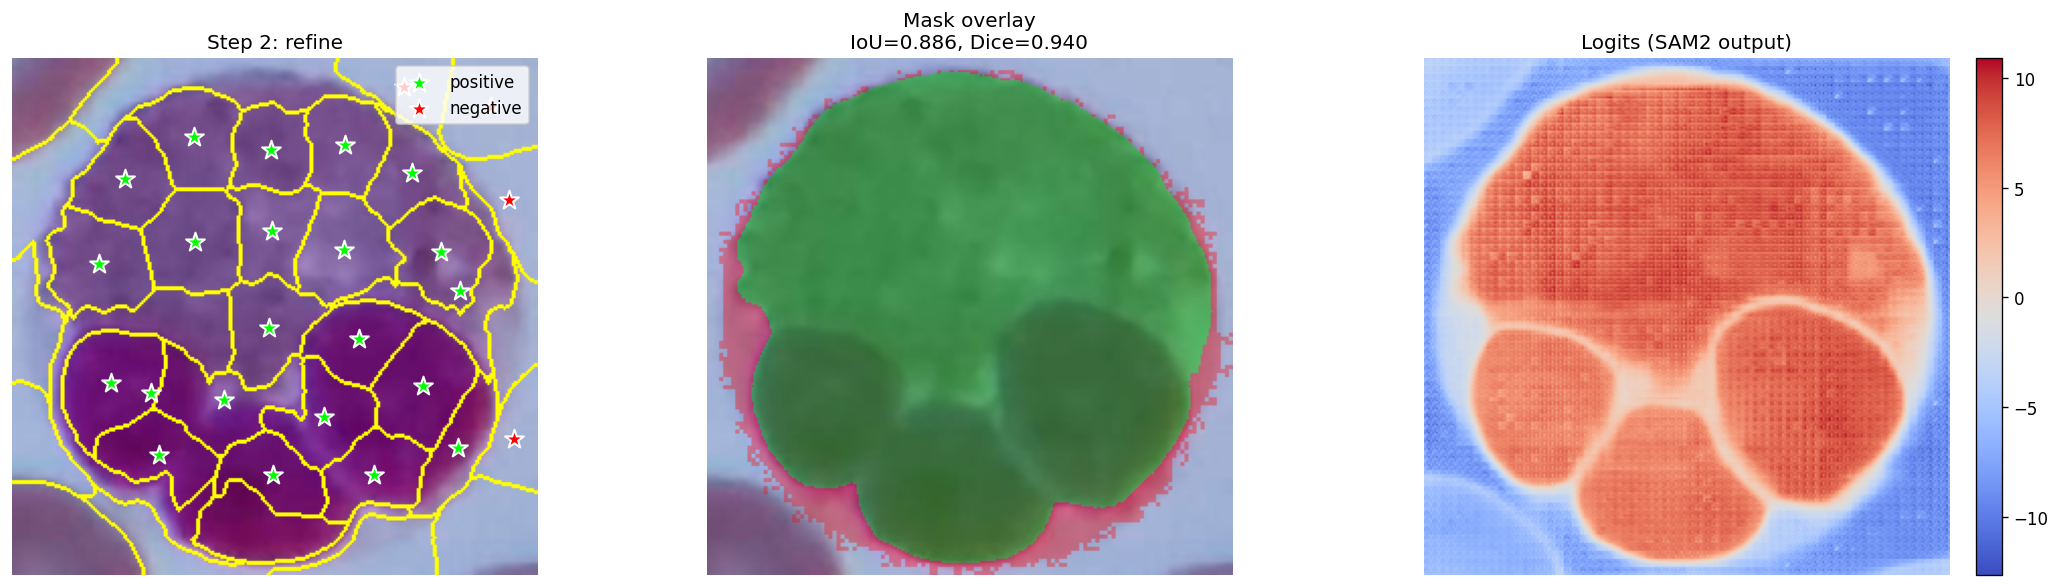

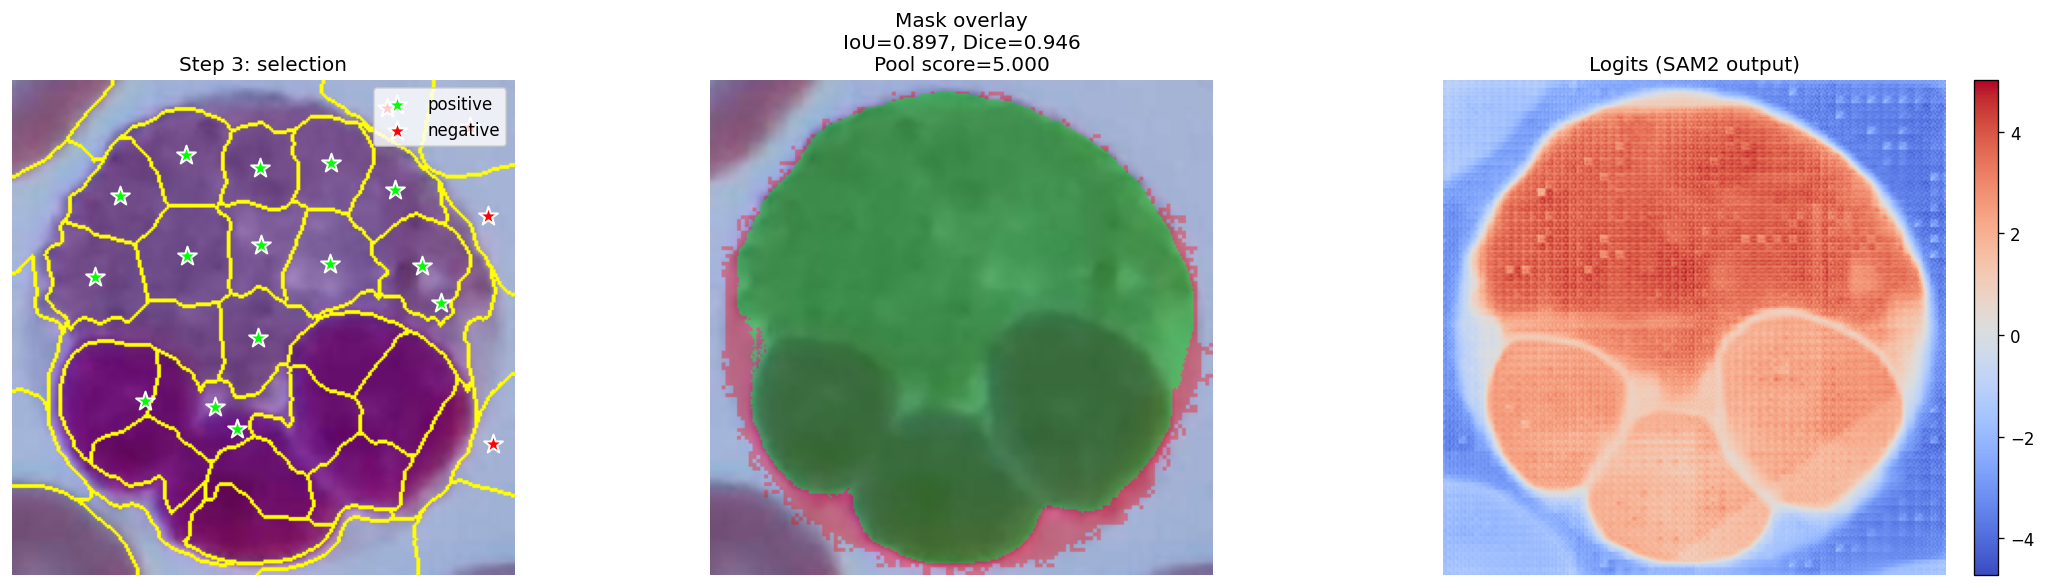

In [8]:
# Visualise each recorded step -------------------------------------------
for idx, step in enumerate(history):
    describe_step(idx, step)


In [9]:
# Summarise the mask pool and scoring -------------------------------------
pool_rows = []
for rank, entry in enumerate(info.get_mask_pool(), start=1):
    details = entry.get("score_details", {})
    raw = details.get("raw", {})
    pool_rows.append({
        "rank": rank,
        "iteration": entry.get("iteration"),
        "candidate_id": entry.get("candidate_id"),
        "pool_score": details.get("score"),
        "score_area": details.get("area_n"),
        "score_edge": details.get("edge_n"),
        "score_circ": details.get("circ_n"),
        "score_conv": details.get("conv_quality_n"),
        "score_bcs": details.get("bcs_n"),
        "area_ratio": raw.get("area_ratio"),
        "edge_raw": raw.get("edge"),
        "circularity_raw": raw.get("circularity"),
        "conv_quality_raw": entry.get("conv_quality"),
        "bcs_raw": raw.get("bcs"),
        "iou_vs_gt": Info._mask_iou(entry["mask"], gt_mask_aligned),
    })

try:
    import pandas as pd
    df = pd.DataFrame(pool_rows)
    if not df.empty:
        df = df.sort_values("pool_score", ascending=False)
    display(df)
except Exception:
    print(pool_rows)

if pool_stats:
    display(Markdown("**Normalisation ranges used for scoring:**"))
    try:
        import pandas as pd
        trimmed_stats = {k: v for k, v in pool_stats.items() if k not in ("target_area_ratio", "raw_features")}
        stats_df = pd.DataFrame(trimmed_stats)
        display(stats_df)
    except Exception:
        print(pool_stats)
else:
    print("Pool stats unavailable (no selection stage run).")

if pool_stats:
    display(Markdown(f"Target area ratio (prior): **{pool_stats.get('target_area_ratio', float('nan')):.3f}**"))


[{'rank': 1, 'iteration': 1, 'candidate_id': 20, 'pool_score': 5.0, 'score_area': 1.0, 'score_edge': 1.0, 'score_circ': 1.0, 'score_conv': 1.0, 'score_bcs': 0.9999999999999997, 'area_ratio': 0.6573016826923077, 'edge_raw': 0.0620406344913176, 'circularity_raw': 0.5067488218167183, 'conv_quality_raw': 0.9786519408226013, 'bcs_raw': 1.708059198871641, 'iou_vs_gt': 0.8970724571993655}, {'rank': 2, 'iteration': 0, 'candidate_id': None, 'pool_score': -1.5518608200501463e-16, 'score_area': 0.0, 'score_edge': 0.0, 'score_circ': 0.0, 'score_conv': 0.0, 'score_bcs': -1.5518608200501463e-16, 'area_ratio': 0.34927884615384613, 'edge_raw': 0.02359624479189576, 'circularity_raw': 0.25329672986829277, 'conv_quality_raw': 0.940629780292511, 'bcs_raw': 0.9926451551114015, 'iou_vs_gt': 0.48054687984776717}]


**Normalisation ranges used for scoring:**

{'area': {'min': -0.3007211538461539, 'max': -0.007301682692307687}, 'edge': {'min': 0.02359624479189576, 'max': 0.0620406344913176}, 'circularity': {'min': 0.25329672986829277, 'max': 0.5067488218167183}, 'conv_quality': {'min': 0.940629780292511, 'max': 0.9786519408226013}, 'bcs': {'min': 0.9926451551114016, 'max': 1.7080591988716411}, 'target_area_ratio': 0.65, 'raw_features': [{'area': -0.007301682692307687, 'area_ratio': 0.6573016826923077, 'edge': 0.0620406344913176, 'circularity': 0.5067488218167183, 'conv_quality': 0.9786519408226013, 'bcs': 1.7080591988716411}, {'area': -0.3007211538461539, 'area_ratio': 0.34927884615384613, 'edge': 0.02359624479189576, 'circularity': 0.25329672986829277, 'conv_quality': 0.940629780292511, 'bcs': 0.9926451551114016}]}


Target area ratio (prior): **0.650**

Top candidates by pool score:
#1: iteration=1, candidate=20, score=5.0000
#2: iteration=0, candidate=None, score=-0.0000


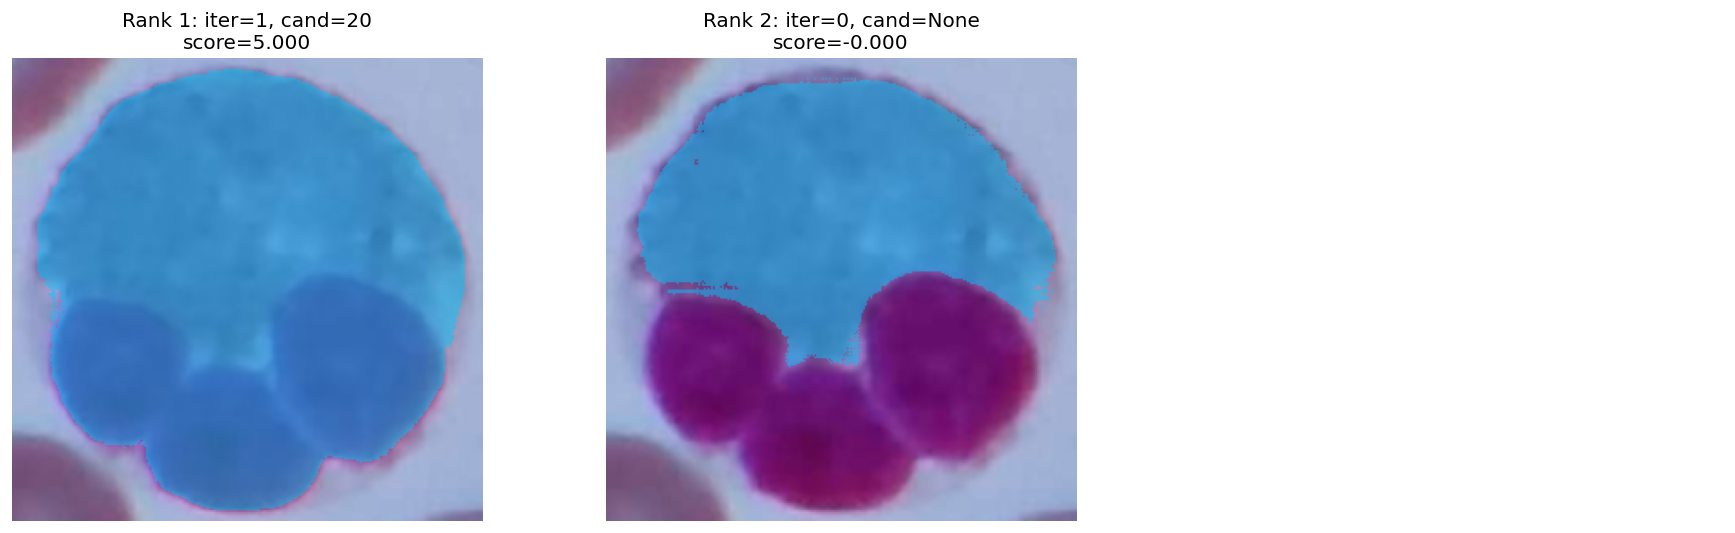

In [10]:
# Visualise candidate masks ranked by pool scores -------------------------
mask_pool_full = info.get_mask_pool(full=True)
mask_pool = info.get_mask_pool()
if not mask_pool:
    print("Mask pool is empty; no candidate visualisations available.")
else:
    scored_entries = sorted(
        mask_pool,
        key=lambda entry: entry.get("score_details", {}).get("score", float('-inf')),
        reverse=True,
    )
    print("Top candidates by pool score:")
    for rank, entry in enumerate(scored_entries[: min(10, len(scored_entries))], start=1):
        details = entry.get("score_details", {})
        score = details.get("score")
        iteration = entry.get("iteration")
        cand = entry.get("candidate_id")
        score_text = f"{score:.4f}" if score is not None else "NA"
        print(f"#{rank}: iteration={iteration}, candidate={cand}, score={score_text}")
    n_cols = 3
    n_rows = int(np.ceil(len(scored_entries) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
    for idx, entry in enumerate(scored_entries):
        ax = axes[idx // n_cols, idx % n_cols]
        overlay = overlay_mask(vis_image, entry["mask"], color=(0, 200, 255), alpha=0.5)
        ax.imshow(overlay)
        details = entry.get("score_details", {})
        score = details.get("score")
        iteration = entry.get("iteration")
        cand = entry.get("candidate_id")
        title = f"Rank {idx + 1}: iter={iteration}, cand={cand}"
        if score is not None:
            title += f"\nscore={score:.3f}"
        ax.set_title(title)
        ax.axis('off')
    for ax in axes.ravel()[len(scored_entries):]:
        ax.axis('off')
    plt.tight_layout()


Selected middle cluster with 1 masks (area center=0.6573).


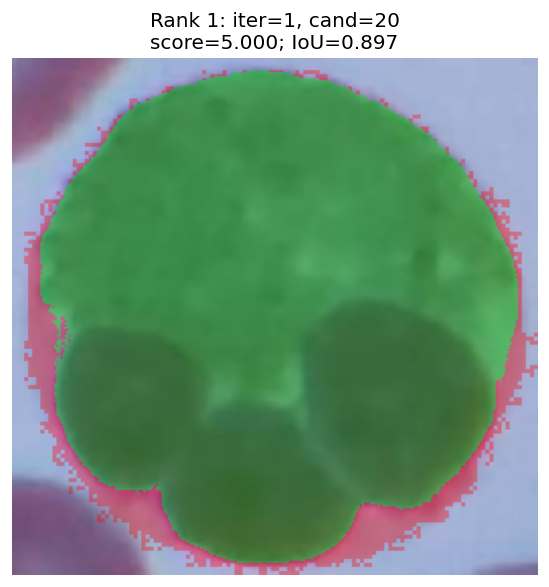

In [11]:
# Clustered middle mask overlays (post-NMS pool) -----------------------------
if not mask_pool:
    print("Mask pool is empty; no overlays to display.")
else:
    middle_entries, cluster_meta = cluster_masks_by_area(mask_pool, n_clusters=3)
    if middle_entries:
        centers = cluster_meta.get("centers", [])
        if centers:
            centers_arr = np.array(centers)
            sorted_centers = np.sort(centers_arr)
            selected_center = sorted_centers[len(sorted_centers) // 2]
            print(f"Selected middle cluster with {len(middle_entries)} masks (area center={selected_center:.4f}).")
        else:
            print(f"Selected middle cluster with {len(middle_entries)} masks.")
        target_entries = middle_entries
    else:
        print("Middle cluster empty; falling back to displaying all deduplicated masks.")
        target_entries = mask_pool
    sorted_entries = sorted(
        target_entries,
        key=lambda entry: entry.get("score_details", {}).get("score", float('-inf')),
        reverse=True,
    )
    n_cols = min(3, len(sorted_entries))
    n_rows = int(np.ceil(len(sorted_entries) / max(1, n_cols)))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
    for idx, entry in enumerate(sorted_entries):
        ax = axes[idx // n_cols, idx % n_cols]
        mask_bool = np.asarray(entry["mask"], dtype=bool)
        overlay = overlay_mask(vis_image, mask_bool, (0, 220, 0), alpha=0.45)
        overlay = overlay_mask(overlay, np.logical_and(gt_mask_aligned, ~mask_bool), (255, 0, 0), alpha=0.35)
        ax.imshow(overlay)
        details = entry.get("score_details", {})
        score = details.get("score")
        iou = Info._mask_iou(mask_bool, gt_mask_aligned)
        title = f"Rank {idx + 1}: iter={entry.get('iteration')}"
        cand = entry.get("candidate_id")
        if cand is not None:
            title += f", cand={cand}"
        if score is not None:
            title += f"\nscore={score:.3f}"
        title += f"; IoU={iou:.3f}"
        ax.set_title(title)
        ax.axis('off')
    for ax in axes.ravel()[len(sorted_entries):]:
        ax.axis('off')
    plt.tight_layout()


In [ ]:
# Entropy-based mask selection


pool = info.get_mask_pool()
entropy_entry, entropy_stats, entropy_scores = pick_obj_using_entropy(vis_image, pool)
entropy_entry


In [ ]:

# Visualise lowest-entropy candidates
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

top_n = min(5, len(pool))
entries = []
gt = locals().get('gt_mask_aligned') if 'gt_mask_aligned' in locals() else None
for entry, score_detail in zip(pool, entropy_scores):
    mask_bool = entry['mask'].astype(bool)
    iou = 0.0
    if gt is not None:
        inter = (mask_bool & gt).sum()
        union = (mask_bool | gt).sum()
        if union > 0:
            iou = inter / union
    score = None
    sd = entry.get('score_details') or {}
    if 'score' in sd:
        score = sd['score']
    elif entry.get('score') is not None:
        score = entry['score']
    entries.append({'entry': entry, 'entropy': score_detail['entropy'], 'iou': iou, 'score': score})

entries_sorted = sorted(entries, key=lambda x: x['entropy'])
fig, axes = plt.subplots(1, max(1, top_n), figsize=(5*max(1, top_n), 5))
if max(1, top_n) == 1:
    axes = [axes]
for ax, item in zip(axes, entries_sorted[:top_n]):
    overlay = mark_boundaries(img_as_float(vis_image), item['entry']['mask'].astype(bool), color=(1,0,0))
    ax.imshow(overlay)
    title = f"entropy={item['entropy']:.3f}"
    title += f"IoU={item['iou']:.3f}"
    if item['score'] is not None:
        title += f"score={item['score']:.3f}"
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Edge-gradient mask selection
edge_entry, edge_stats, edge_scores = pick_obj_using_edge_gradient(vis_image, pool)
edge_entry


In [ ]:

    # Visualise top edge-gradient candidates
    import matplotlib.pyplot as plt
    from skimage.segmentation import mark_boundaries
    from skimage.util import img_as_float

    top_n = min(5, len(pool))
    entries = []
    gt = locals().get('gt_mask_aligned') if 'gt_mask_aligned' in locals() else None
    for entry, sd in zip(pool, edge_scores):
        mask_bool = entry['mask'].astype(bool)
        iou = 0.0
        if gt is not None:
            inter = (mask_bool & gt).sum()
            union = (mask_bool | gt).sum()
            if union > 0:
                iou = inter / union
        edge_score = sd.get('edge_score', 0.0)
        score = entry.get('score')
        entries.append({'entry': entry, 'edge_score': edge_score, 'iou': iou, 'score': score})

    entries_sorted = sorted(entries, key=lambda x: x['edge_score'], reverse=True)
    fig, axes = plt.subplots(1, max(1, top_n), figsize=(5*max(1, top_n), 5))
    if max(1, top_n) == 1:
        axes = [axes]
    for ax, item in zip(axes, entries_sorted[:top_n]):
        overlay = mark_boundaries(img_as_float(vis_image), item['entry']['mask'].astype(bool), color=(0,1,0))
        ax.imshow(overlay)
        title = f"edge={item['edge_score']:.3f}"
        title += f"
IoU={item['iou']:.3f}"
        if item['score'] is not None:
            title += f"
score={item['score']:.3f}"
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
